In [109]:
!pip install pandas numpy matplotlib scipy



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [110]:
import matplotlib.pyplot as plt
import numpy as np
import re

import pandas as pd


In [111]:
def parse_accelerometer_csv(filepath):
    """
    Parse accelerometer CSV data with format:
    time:XXX, acc_x:XXX, acc_y:XXX, acc_z:XXX, gyr_x:XXX, gyr_y:XXX, gye_z:XXX, mag_x:XXX, mag_y:XXX, mag_z:XXX, temp:XXX

    Returns a pandas DataFrame with columns for each measurement.
    Missing values are filled with NaN.
    """
    # Define patterns for each field
    field_patterns = {
        "time": r"time:(-?\d+)",
        "acc_x": r"acc_x:(-?\d+\.?\d*)",
        "acc_y": r"acc_y:(-?\d+\.?\d*)",
        "acc_z": r"acc_z:(-?\d+\.?\d*)",
        "raw_acc_x": r"raw_acc_x:(-?\d+\.?\d*)",
        "raw_acc_y": r"raw_acc_y:(-?\d+\.?\d*)",
        "raw_acc_z": r"raw_acc_z:(-?\d+\.?\d*)",
        "gyr_x": r"gyr_x:(-?\d+\.?\d*)",
        "gyr_y": r"gyr_y:(-?\d+\.?\d*)",
        "gyr_z": r"gye_z:(-?\d+\.?\d*)",  # Note: matches typo 'gye_z' in data
        "mag_x": r"mag_x:(-?\d+\.?\d*)",
        "mag_y": r"mag_y:(-?\d+\.?\d*)",
        "mag_z": r"mag_z:(-?\d+\.?\d*)",
        "temp": r"temp:(-?\d+\.?\d*)",
    }

    data = {key: [] for key in field_patterns}

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            for field, pattern in field_patterns.items():
                match = re.search(pattern, line)
                if match:
                    value = (
                        int(match.group(1))
                        if field == "time"
                        else float(match.group(1))
                    )
                    data[field].append(value)
                else:
                    data[field].append(float("nan"))

    return pd.DataFrame(data)


In [112]:
data = parse_accelerometer_csv("./filtered_accelerometer.csv")


In [113]:
data["ang_x"] = np.degrees(np.arctan2(data["acc_y"], data["acc_z"]))
data["ang_y"] = np.degrees(
    np.arctan2(-data["acc_x"], np.sqrt(data["acc_y"] ** 2 + data["acc_z"] ** 2))
)


In [114]:
data


,time,acc_x,acc_y,acc_z,raw_acc_x,raw_acc_y,raw_acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,temp,ang_x,ang_y
0,8810462,-9.50,9.58,1020.24,-12.21,5.86,1019.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537989,0.533473
1,8821576,-9.06,8.84,1020.59,-7.32,5.86,1021.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496264,0.508595
2,8832591,-8.52,10.39,1020.28,-6.35,16.60,1019.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.583450,0.478421
3,8843791,-9.45,10.85,1021.01,-13.18,12.70,1023.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.608844,0.530258
4,8855075,-11.76,10.34,1022.28,-21.00,8.30,1027.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.579507,0.659051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,37323807,-5.21,7.53,1022.04,-3.91,3.91,1024.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.422126,0.292063
2462,37334915,-6.02,7.59,1022.61,-9.28,7.81,1024.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.425252,0.337281
2463,37346024,-8.82,9.20,1023.95,-20.02,15.63,1029.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.514778,0.493497
2464,37357302,-6.38,10.68,1022.48,3.42,16.60,1016.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598444,0.357486


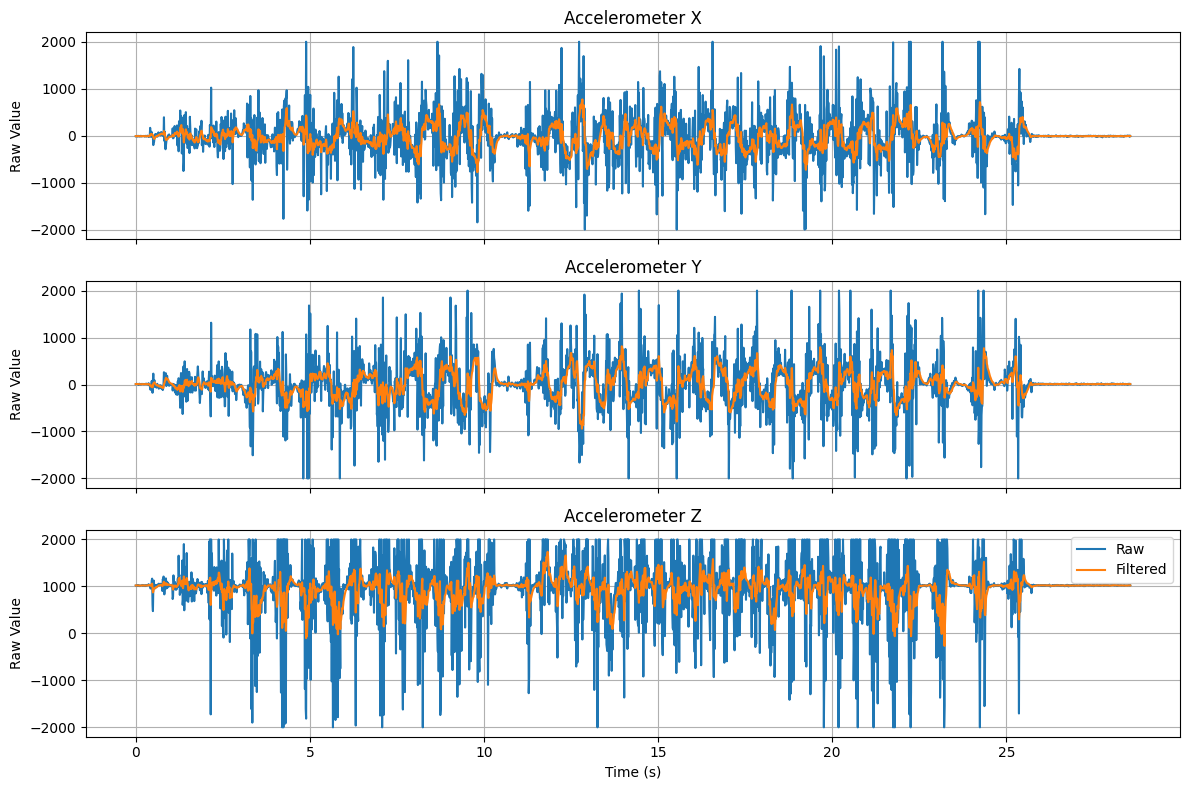

In [115]:

seconds = (data["time"] - np.min(data["time"])) / (10**6)
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axes[0].plot(seconds, data["raw_acc_x"], label="Raw")
axes[0].plot(seconds, data["acc_x"], label="Filtered")
axes[0].set_ylabel("Raw Value")
axes[0].set_title("Accelerometer X")
axes[0].grid(True)
axes[1].plot(seconds, data["raw_acc_y"], label="Raw")
axes[1].plot(seconds, data["acc_y"], label="Filtered")
axes[1].set_ylabel("Raw Value")
axes[1].set_title("Accelerometer Y")
axes[1].grid(True)
axes[2].plot(seconds, data["raw_acc_z"], label="Raw")
axes[2].plot(seconds, data["acc_z"], label="Filtered")
axes[2].set_ylabel("Raw Value")
axes[2].set_title("Accelerometer Z")
axes[2].set_xlabel("Time (s)")
axes[2].legend()
axes[2].grid(True)
plt.tight_layout()
plt.show()


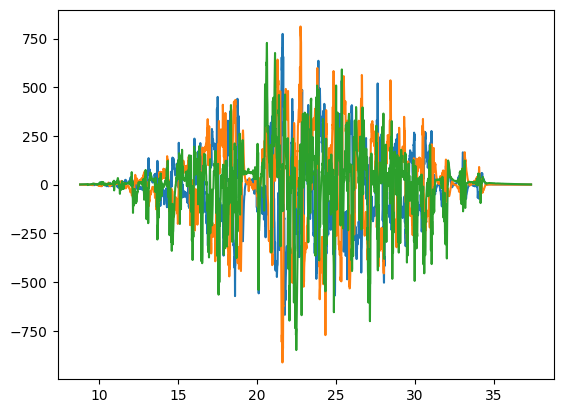

In [116]:
from scipy.signal.windows import dpss

window = dpss(len(data), 2)


times = data["time"] / (10 ** 6)
dts = np.diff(times)
average_dt = np.mean(dts)

windowed_acc_x = window * (data["acc_x"] - np.mean(data["acc_x"]))
windowed_acc_y = window * (data["acc_y"] - np.mean(data["acc_y"]))
windowed_acc_z = window * (data["acc_z"] - np.mean(data["acc_z"]))
windowed_raw_acc_x = window * (data["raw_acc_x"] - np.mean(data["raw_acc_x"]))
windowed_raw_acc_y = window * (data["raw_acc_y"] - np.mean(data["raw_acc_y"]))
windowed_raw_acc_z = window * (data["raw_acc_z"] - np.mean(data["raw_acc_z"]))

plt.plot(times, windowed_acc_x)
plt.plot(times, windowed_acc_y)
plt.plot(times, windowed_acc_z)


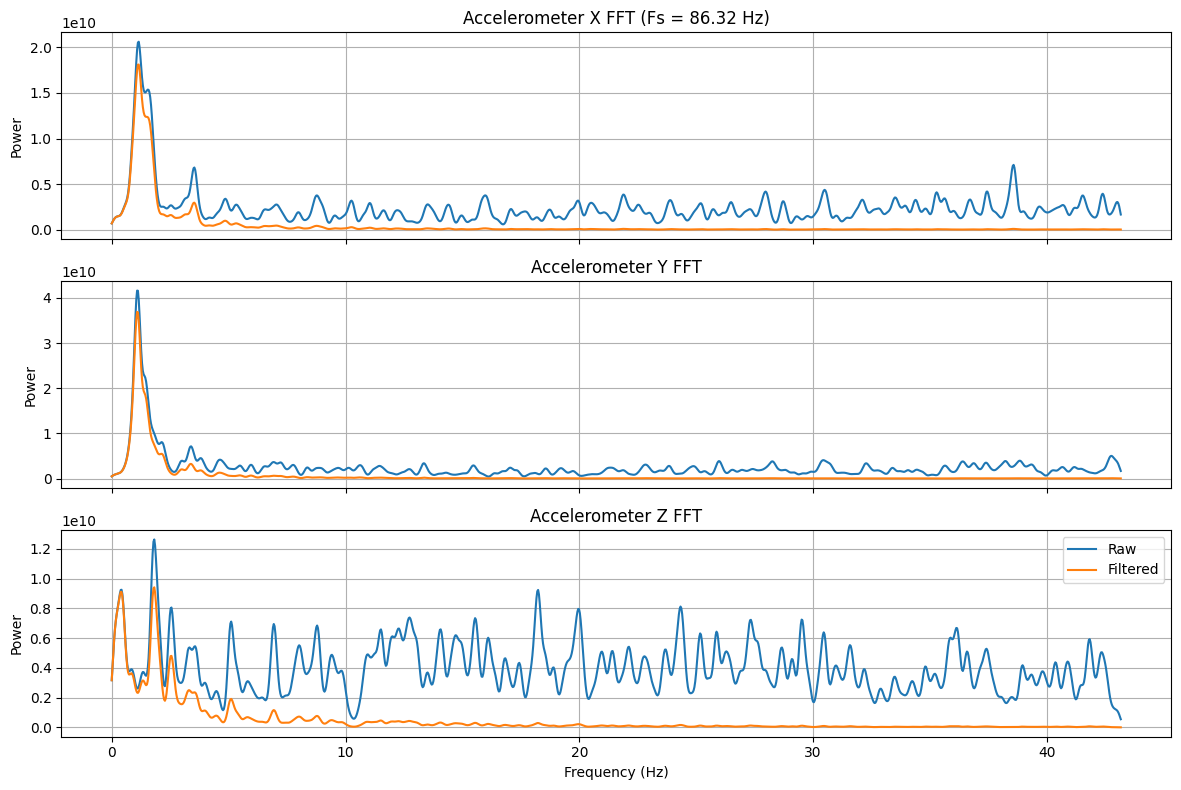

Sampling frequency: 86.32 Hz
Nyquist frequency: 43.16 Hz
Frequency resolution: 0.0350 Hz


In [122]:
def process(data):
    power = np.square(np.abs(np.fft.rfft(data)))
    conv = dpss(32, 8)
    return np.convolve(power, conv, mode="same")

fft_acc_x = process(windowed_acc_x)
fft_acc_y = process(windowed_acc_y)
fft_acc_z = process(windowed_acc_z)

fft_raw_acc_x = process(windowed_raw_acc_x)
fft_raw_acc_y = process(windowed_raw_acc_y)
fft_raw_acc_z = process(windowed_raw_acc_z)

# Calculate sampling frequency and frequency bins
fs = 1.0 / average_dt  # Sampling frequency in Hz
n_samples = len(data)
freqs = np.fft.rfftfreq(n_samples, d=average_dt)  # Frequency bins in Hz
# Plot the power spectra
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axes[0].plot(freqs, fft_raw_acc_x, label="Raw")
axes[0].plot(freqs, fft_acc_x, label="Filtered")
axes[0].set_ylabel("Power")
axes[0].set_title(f"Accelerometer X FFT (Fs = {fs:.2f} Hz)")
axes[0].grid(True)
axes[1].plot(freqs, fft_raw_acc_y, label="Raw")
axes[1].plot(freqs, fft_acc_y, label="Filtered")
axes[1].set_ylabel("Power")
axes[1].set_title("Accelerometer Y FFT")
axes[1].grid(True)
axes[2].plot(freqs, fft_raw_acc_z, label="Raw")
axes[2].plot(freqs, fft_acc_z, label="Filtered")
axes[2].set_ylabel("Power")
axes[2].set_title("Accelerometer Z FFT")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].legend()
axes[2].grid(True)
plt.tight_layout()
plt.show()
print(f"Sampling frequency: {fs:.2f} Hz")
print(f"Nyquist frequency: {fs / 2:.2f} Hz")
print(f"Frequency resolution: {freqs[1] - freqs[0]:.4f} Hz")


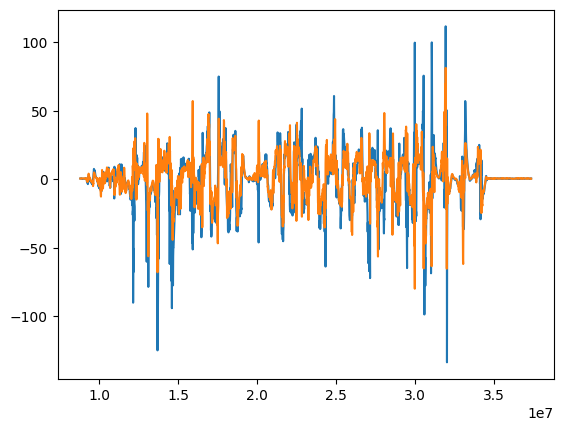

In [118]:
plt.plot(data["time"], data["ang_x"])
plt.plot(data["time"], data["ang_y"])

